In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import hamming_loss
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
def scaleMatrix(matrix):
    return matrix.div(matrix.sum(axis=1),axis=0)

In [3]:
def norm(series):
    b = max(series)
    a = min(series)
    return [(x - a) / (b - a) for x in series]

In [4]:
def npmc(init_state, matrix, original_states, init_state_col):
    matrix = scaleMatrix(matrix)
    probs = {k:list(matrix.iloc[original_states.index(k)]) for k in original_states}
    NewState = []
    for x in range(len(init_state)):
        NewState.append(np.random.choice(a = matrix.columns, p = probs[init_state[init_state_col][x]],size=1)[0])
    NextStep = pd.DataFrame()
    NextStep["Original State"] = init_state[init_state_col]
    NextStep["New State"] = NewState
    return NextStep

In [5]:
def chain(init_state, matrix, original_states, init_state_col,n):
    init_state = init_state.copy()
    out = pd.DataFrame()
    out[0] = init_state[init_state_col]
    for i in range(1,n+1):
        out[i] = npmc(out,matrix,original_states,i-1)["New State"]
    return out

In [6]:
def proj(inp,X1,X2,n,start_state_col):
    sts = []
    inp.reset_index(drop = True,inplace = True)
    curr_st = inp[start_state_col].iloc[0]
    for step in range(n):
        sts.append(curr_st)
        if curr_st == -1:
            try:
                up_prob = npdfd["t1"].iloc[downknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[1] / n_neighbors
            except:
                up_prob = 0
            try:
                down_prob = npdfd["t1"].iloc[downknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[0] / n_neighbors
            except:
                down_prob = 1- up_prob
            curr_st = np.random.choice([0,1],1,p = [down_prob, up_prob])[0]
        else:
            try:
                up_prob = npdfu["t1"].iloc[upknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[1] / n_neighbors
            except:
                up_prob = 0
            try:
                down_prob = npdfu["t1"].iloc[upknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[0] / n_neighbors
            except:
                down_prob = 1 - up_prob
            curr_st = np.random.choice([0,1],1,p = [down_prob, up_prob])[0]
    return sts

In [7]:
tick = pd.read_csv("NASDAQ_Ticks.csv")
all_data = {}
all_tm = {}
returns = {}
for x in tick["Ticker"]:
    
    df = pd.DataFrame()
    t0 = pd.read_csv(x+".csv")["Adj Close"]
    if len(t0) > 60:
        returns[x] = t0.pct_change().iloc[::3][1:]
        df["MMYYYY"] = [x[5:7] + x[:4] for x in pd.read_csv(x+".csv")["Date"][1:]]
        df.reset_index(drop = True,inplace = True)
        df["t0"] = np.where(t0.pct_change()[1:] > 0, 1, 0)
        df.dropna(inplace=True)
        df.reset_index(drop = True,inplace = True)

        df["t1"] = df["t0"].shift(-3)
        df.dropna(inplace=True)
        df.reset_index(drop = True,inplace = True)

        states = ["Up","Down"]
        TM = pd.DataFrame(index = ["Up","Down"])

        tm = {"UU":0,"UD":0,"DU":0,"DD":0}

        for i in range(2,len(df)):

            if df["t0"][i] == 1 and df["t0"][i-1] == 1:
                tm["UU"] += 1
            elif df["t0"][i] == 0 and df["t0"][i-1] == 1:
                tm["UD"] += 1
            elif df["t0"][i] == 1 and df["t0"][i-1] == 0:
                tm["DU"] += 1
            else:
                tm["DD"] += 1

        TM["Up"] = [tm["UU"],tm["UD"]]
        TM["Down"] = [tm["DU"],tm["DD"]]

        findf = pd.read_csv(x + "_quarterly_valuation_measures.csv",header=None).T
        findf.columns = findf.iloc[0]
        findf.drop([0,1],inplace=True)

        findf1 = pd.DataFrame()
        findf1["MMYYYY"] = [y[:2]+ y[6:10] for y in findf["name"].str.replace('/', '-')]
        try:
            findf1["PeRatio"] = norm(np.log(findf["PeRatio"].str.replace(',', '').astype(float)+1))
        except:
            findf1["PeRatio"] = norm(np.log(findf["PegRatio"].str.replace(',', '').astype(float)*0.18+1))
        findf1["PsRatio"] = norm(np.log(findf["PsRatio"].str.replace(',', '').astype(float)+1))
        findf1["PbRatio"] = norm(np.log(findf["PbRatio"].str.replace(',', '').astype(float)+1))
        findf1['MarketCap'] = norm(np.log(findf['MarketCap'].str.replace(',', '').astype(float)+1))
        findf1['EV'] = norm(np.log(findf['EnterpriseValue'].str.replace(',', '').astype(float)+1))
        findf1['EVtoEBITDA'] = norm(np.log(findf['EnterprisesValueEBITDARatio'].str.replace(',', '').astype(float)+1))
        findf1.interpolate(method='linear',inplace=True)

        findf1.dropna(inplace=True)
        findf1.reset_index(drop = True,inplace = True)

        alldf = df.merge(right=findf1, on = ["MMYYYY"])
        if len(alldf) > 5:
            all_tm[x] = scaleMatrix(TM)
            all_data[x] = alldf
    len(all_data)
    for x in all_data.keys():
        pca = PCA(n_components=1)
        all_data[x]["Z"] = pca.fit_transform(all_data[x][["PeRatio","PsRatio","PbRatio"]])
    for x in all_data.keys():
        pca = PCA(n_components=1)
        all_data[x]["Y"] = pca.fit_transform(all_data[x][["MarketCap","EVtoEBITDA","EV"]])

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-pack

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-pack

In [8]:
pve=[]
for x in all_data.keys():
    pca = PCA(n_components=1)
    pca.fit(all_data[x][["MarketCap","EVtoEBITDA","EV"]])
    pve.append(pca.explained_variance_ratio_)
min(pve)

array([0.69823854])

In [9]:
npdf = pd.DataFrame()
tk = []
my = []
t0 = []
t1 = []
y = []
z = []
for x in all_data.keys():
    tk.extend([x for y in range(len(all_data[x]))])
    my.extend([x for x in all_data[x]["MMYYYY"]])
    t0.extend([x for x in all_data[x]["t0"]])
    t1.extend([x for x in all_data[x]["t1"]])
    z.extend([x for x in all_data[x]["Z"]])
    y.extend([x for x in all_data[x]["Y"]])
npdf["Ticker"] = tk
npdf["MMYYYY"] = my
npdf["t0"] = t0
npdf["t1"] = t1
npdf["Z"] = z
npdf["Y"] = y
npdf.head()

,Ticker,MMYYYY,t0,t1,Z,Y
0,AAPL,091985,1,1.0,-0.393132,-0.742865
1,AAPL,121985,1,1.0,-0.282056,-0.644232
2,AAPL,031986,1,0.0,-0.189234,-0.579683
3,AAPL,061986,0,0.0,-0.100322,-0.525429
4,AAPL,091986,0,1.0,-0.175723,-0.558552


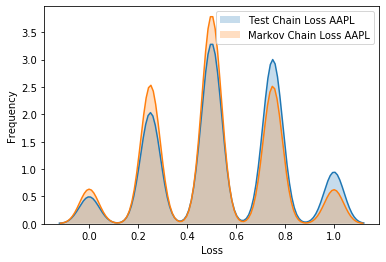

1.2345679012345678% done!


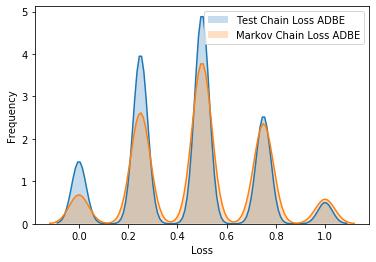

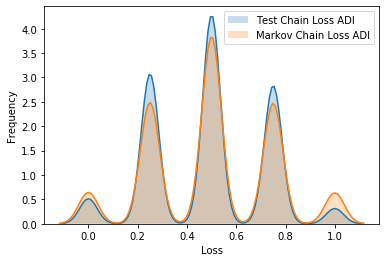

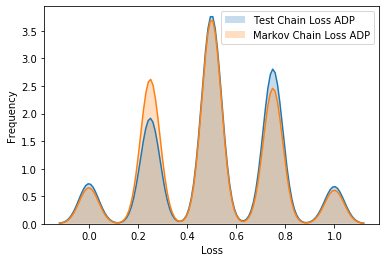

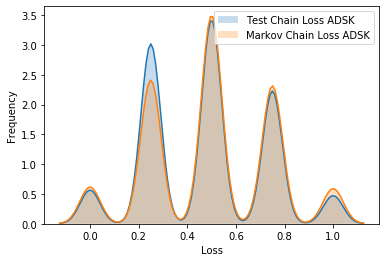

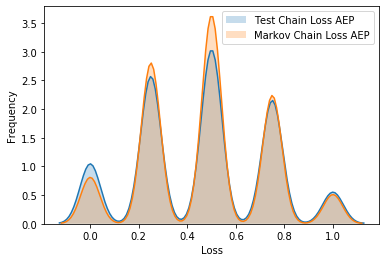

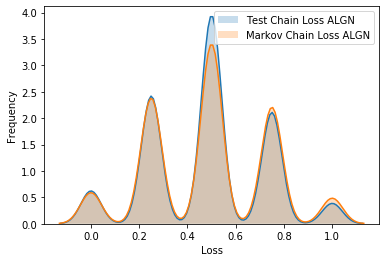

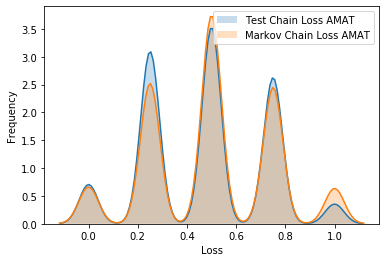

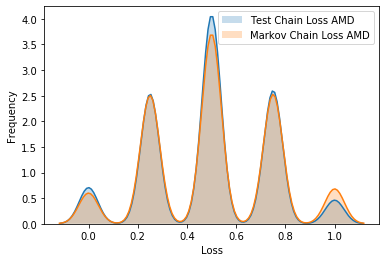

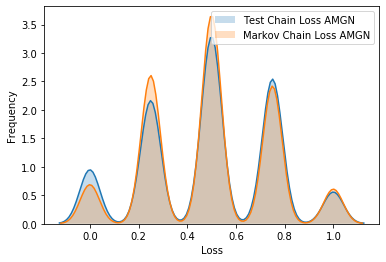

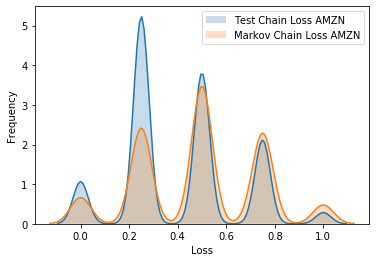

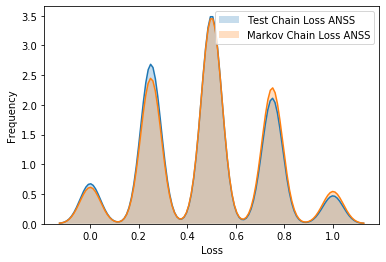

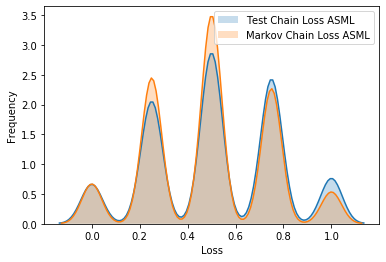

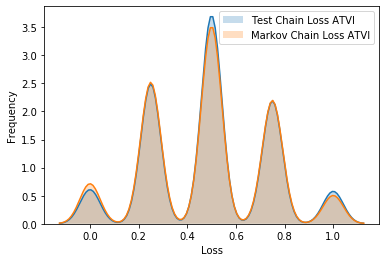

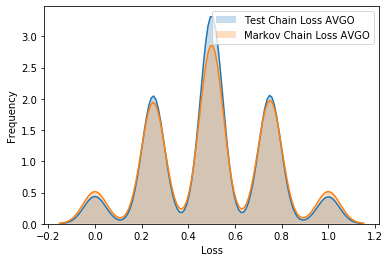

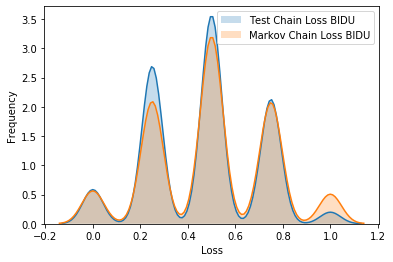

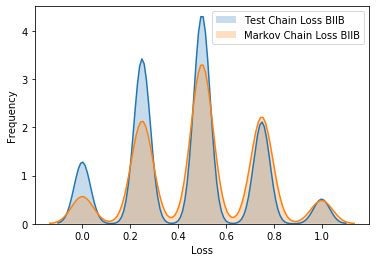

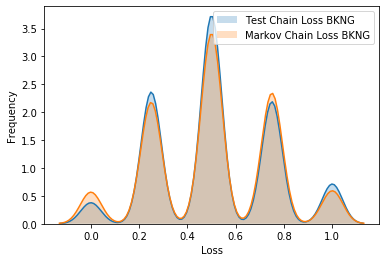

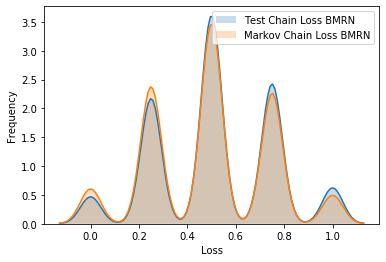

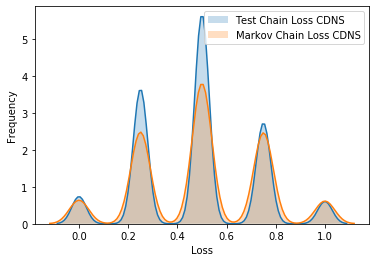

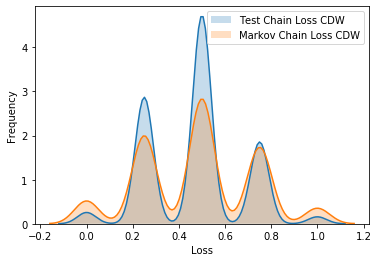

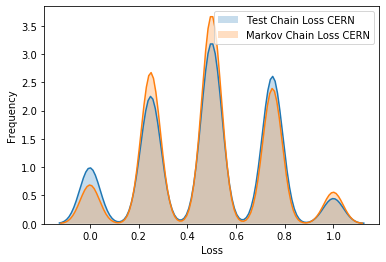

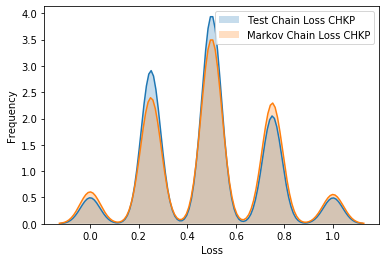

28.395061728395063% done!


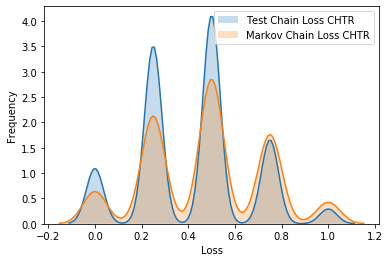

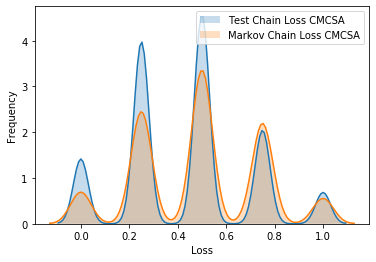

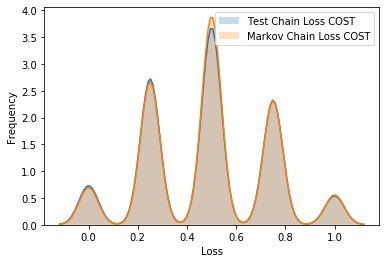

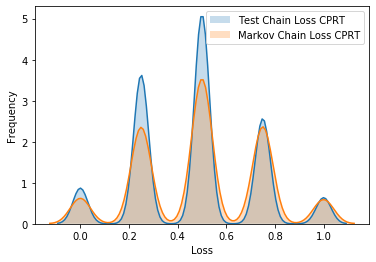

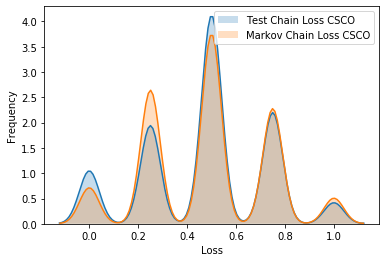

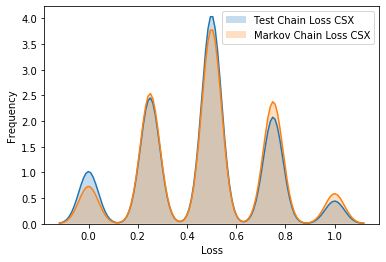

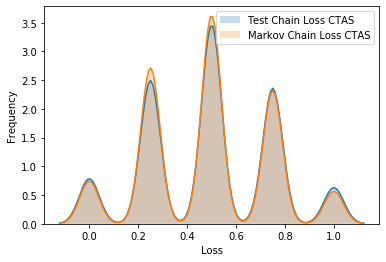

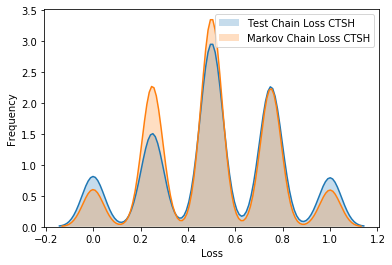

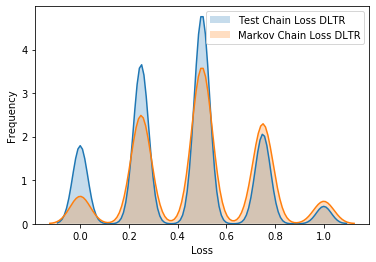

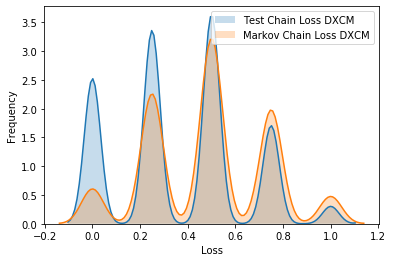

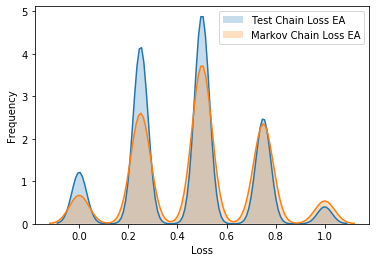

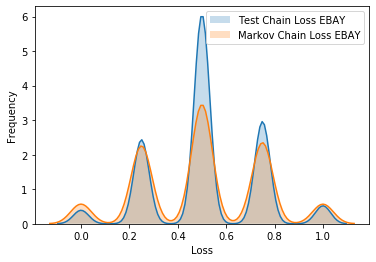

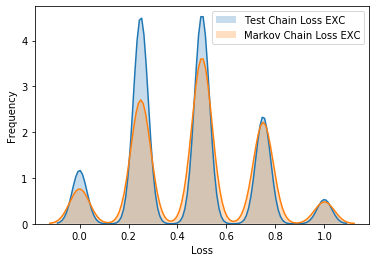

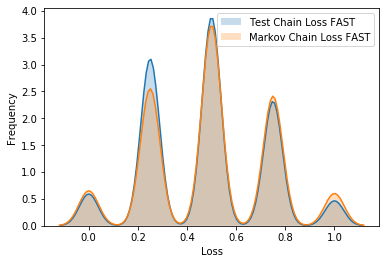

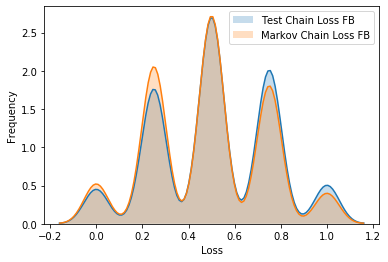

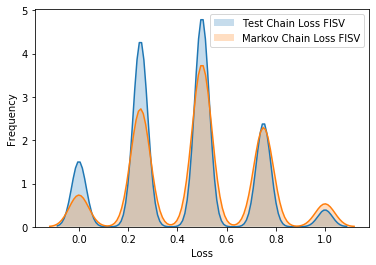

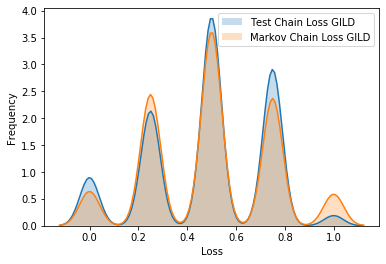

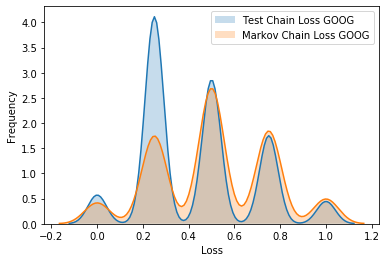

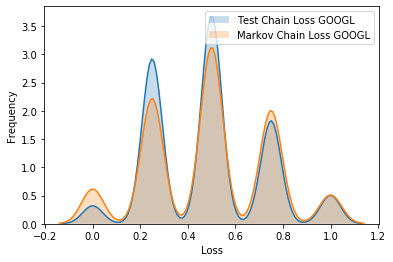

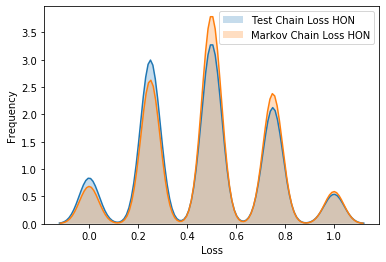

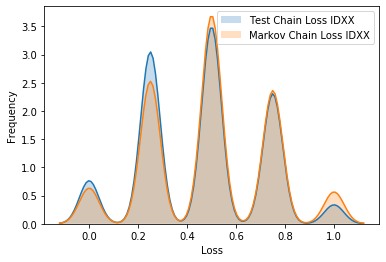

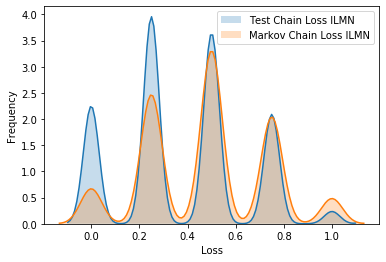

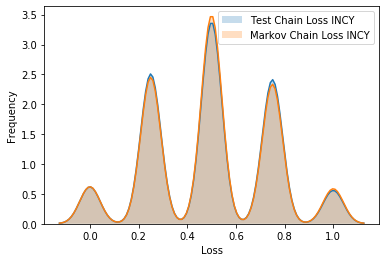

56.79012345679013% done!


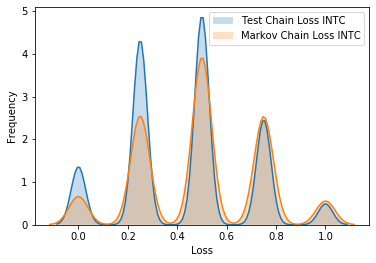

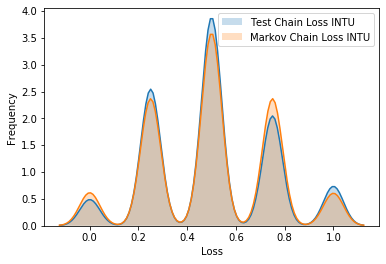

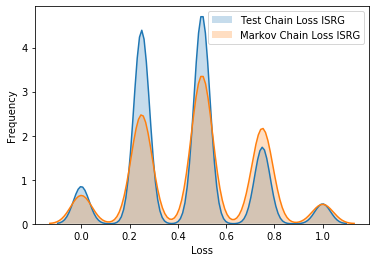

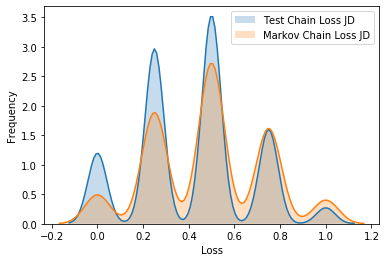

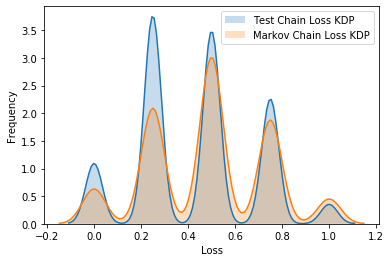

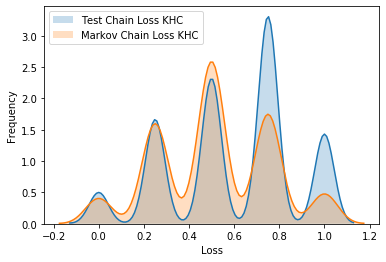

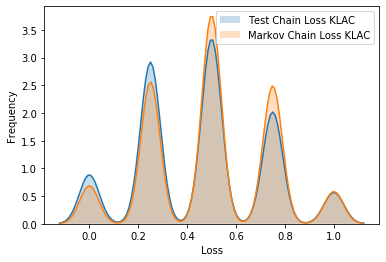

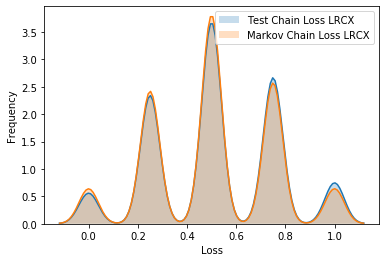

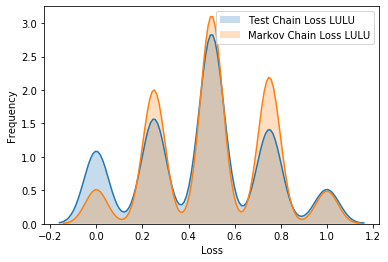

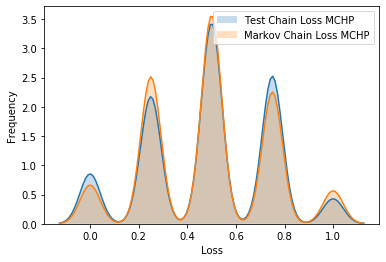

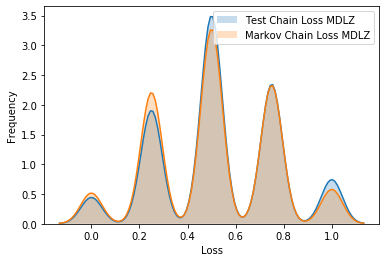

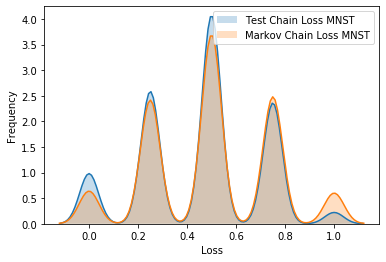

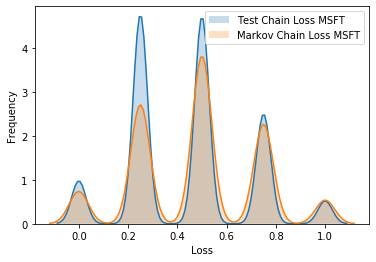

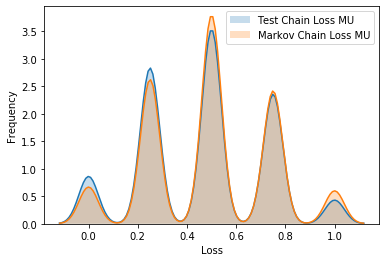

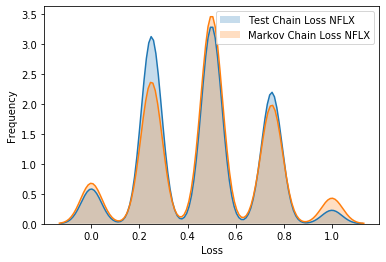

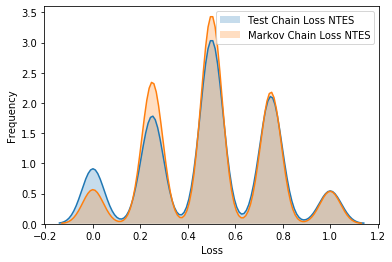

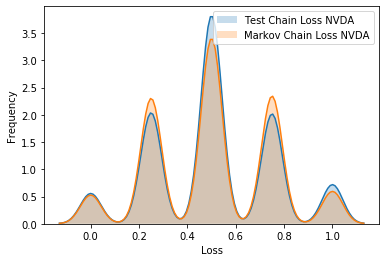

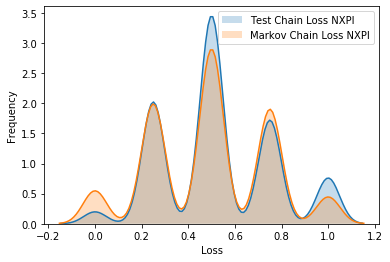

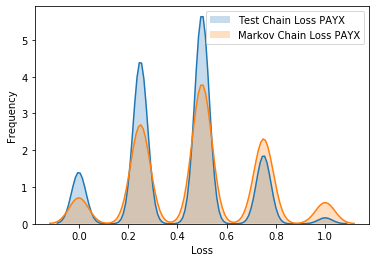

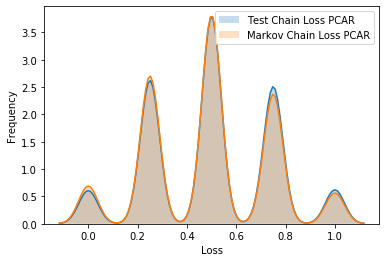

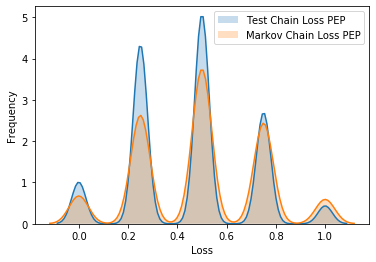

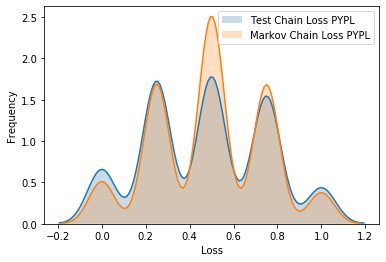

83.95061728395062% done!


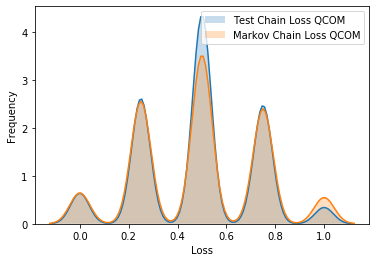

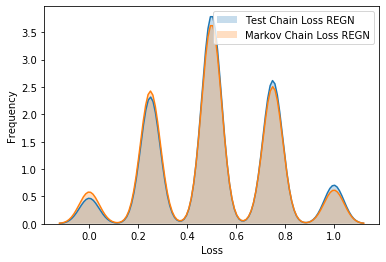

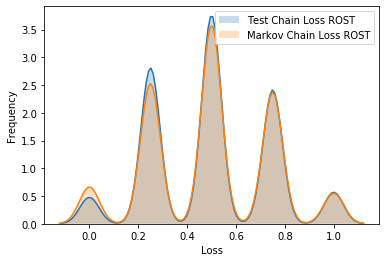

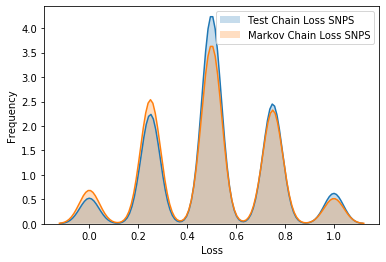

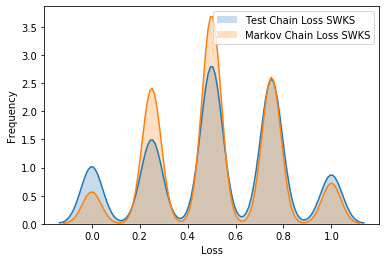

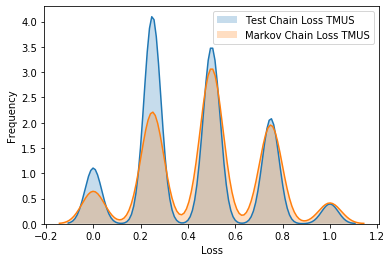

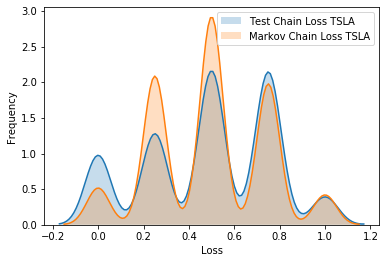

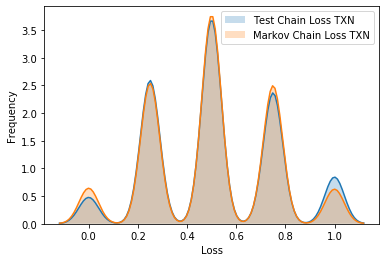

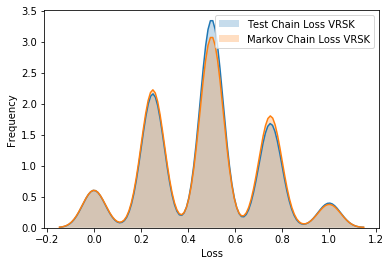

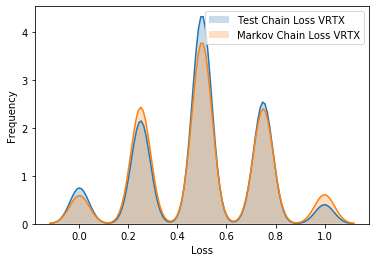

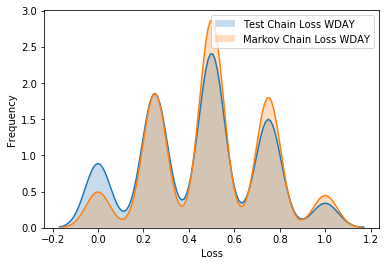

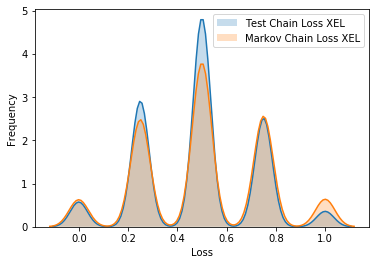

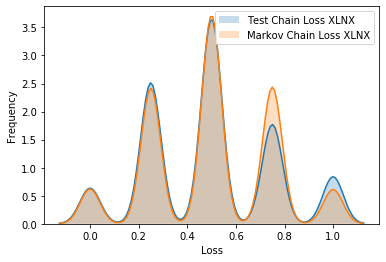

In [10]:
final_out = pd.DataFrame()
final_out["Ticker"] = list(all_data.keys())
testerrorqties = {}
for g in range(len(all_data)):
    if g in [1,23,46,68]:
        print(str(100*g / len(all_data))+"% done!")
    test_comps = [list(all_data.keys())[g]]
    test = npdf.iloc[np.where(npdf["Ticker"] == test_comps[0])]
    train = npdf.iloc[np.where(npdf["Ticker"] != test_comps[0])]
    train.reset_index(drop = True,inplace = True)
    test.reset_index(drop = True,inplace = True)
    npdfu = train.loc[npdf["t0"] == 1]
    npdfd = train.loc[npdf["t0"] == 0]
    n_neighbors = 5
    scale = pd.DataFrame()
    scale["Y"] = norm(npdfu["Y"])
    scale["Z"] = norm(npdfu["Z"])
    upknn = neighbors.KNeighborsClassifier(n_neighbors)
    X = scale[["Y","Z"]]
    y = npdfu["t1"]
    upknn.fit(X,y)
    scale = pd.DataFrame()
    scale["Y"] = norm(npdfd["Y"])
    scale["Z"] = norm(npdfd["Z"])
    downknn = neighbors.KNeighborsClassifier(n_neighbors)
    X = scale[["Y","Z"]]
    y = npdfd["t1"]
    downknn.fit(X,y)
    p = 5
    k = 0
    TEST1 = {}
    test1 = test.loc[test["Ticker"] == test_comps[0]][["t0","t1","Z","Y"]]
    test1.reset_index(drop = True,inplace = True)
    i=0
    while p+k <= len(test1):
        TEST1[i] = test1.iloc[k:p+k]
        k+=1
        i+=1
    np.random.seed(10)
    testloss = []
    n = 100
    for j in range(len(TEST1)):
        for i in range(n):
            out = proj(TEST1[j],"Z","Y",len(TEST1[j]),"t0")
            testloss.append(hamming_loss(out[1:],TEST1[j]["t1"][:len(TEST1[j]["t1"])-1]))
    TM = pd.DataFrame(index = [1,0])

    tm = {"UU":0,"UD":0,"DU":0,"DD":0}

    for x in all_data.keys():
        if x not in test_comps:
            tm["UU"] += all_tm[x]["Up"]["Up"]
            tm["DU"] += all_tm[x]["Down"]["Up"]
            tm["UD"] += all_tm[x]["Up"]["Down"]
            tm["DD"] += all_tm[x]["Down"]["Down"]
    TM[1] = [tm["UU"],tm["UD"]]
    TM[0] = [tm["DU"],tm["DD"]]
    TM = scaleMatrix(TM)
    np.random.seed(10)
    ptstest1 = {}
    for i in range(len(TEST1)):
        ptstest1[i] = pd.DataFrame()
        ptstest1[i]["t0"] = [TEST1[i]["t0"][0]]
    ptsloss = []
    for j in range(len(TEST1)):
        for i in range(n):
            out = chain(init_state = ptstest1[j], matrix = TM, original_states = [1,0], init_state_col = "t0",n=len(TEST1[j])-1)
            ptsloss.append(hamming_loss(out.iloc[0][1:],TEST1[j]["t1"][:len(TEST1[j]["t1"])-1]))
    f = plt.figure(g)
    sns.kdeplot(testloss,shade=True)
    sns.kdeplot(ptsloss,shade=True)
    plt.xlabel("Loss")
    plt.ylabel("Frequency")
    plt.legend(["Test Chain Loss "+str(test_comps[0]),"Markov Chain Loss "+str(test_comps[0])])
    plt.show()
    testerrorqties[test_comps[0]] = {"Proposed Model":[x for x in pd.Series(testloss).describe(percentiles = [0.1+0.1*i for i in range(9)])],"Pure Time Series":[x for x in pd.Series(ptsloss).describe(percentiles = [0.1+0.1*i for i in range(9)])]}

In [11]:
TEST1[j]["t1"][:len(TEST1[j]["t1"])]

0    1.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: t1, dtype: float64

In [12]:
testerrorqties

{'AAPL': {'Proposed Model': [14000.0,
   0.5479464285714286,
   0.2583007907625656,
   0.0,
   0.25,
   0.25,
   0.5,
   0.5,
   0.5,
   0.75,
   0.75,
   0.75,
   0.75,
   1.0],
  'Pure Time Series': [14000.0,
   0.49905357142857143,
   0.24917536111026134,
   0.0,
   0.25,
   0.25,
   0.25,
   0.5,
   0.5,
   0.5,
   0.75,
   0.75,
   0.75,
   1.0]},
 'ADBE': {'Proposed Model': [13500.0,
   0.437,
   0.25127182234749595,
   0.0,
   0.0,
   0.25,
   0.25,
   0.25,
   0.5,
   0.5,
   0.5,
   0.75,
   0.75,
   1.0],
  'Pure Time Series': [13500.0,
   0.4885185185185185,
   0.24941154098564802,
   0.0,
   0.25,
   0.25,
   0.25,
   0.5,
   0.5,
   0.5,
   0.5,
   0.75,
   0.75,
   1.0]},
 'ADI': {'Proposed Model': [13900.0,
   0.485431654676259,
   0.2280629918662865,
   0.0,
   0.25,
   0.25,
   0.25,
   0.5,
   0.5,
   0.5,
   0.5,
   0.75,
   0.75,
   1.0],
  'Pure Time Series': [13900.0,
   0.499136690647482,
   0.24971955495208317,
   0.0,
   0.25,
   0.25,
   0.25,
   0.5,
   0.5,


In [13]:
{"count":0, 
 "mean":1,
 "std":2,
 "min":3,
 "0.1":4,
 "0.2":5,
 "0.3":6,
 "0.4":7,
 "0.5":8,
 "0.6":9,
 "0.7":10,
 "0.8":11,
 "0.9":12,
 "max":13}

{'count': 0,
 'mean': 1,
 'std': 2,
 'min': 3,
 '0.1': 4,
 '0.2': 5,
 '0.3': 6,
 '0.4': 7,
 '0.5': 8,
 '0.6': 9,
 '0.7': 10,
 '0.8': 11,
 '0.9': 12,
 'max': 13}

In [14]:
pctreductionloss = []
avgcap = []
avgpe = []
q = 1
for x in testerrorqties.keys():
    l = (testerrorqties[x]["Pure Time Series"][q] - testerrorqties[x]["Proposed Model"][q]) / testerrorqties[x]["Pure Time Series"][q]
    pctreductionloss.append(l)
    print(l)
    avgcap.append(all_data[x]["Y"][len(all_data[x])-1])
    avgpe.append(all_data[x]["Z"][len(all_data[x])-1])
lossdf = pd.DataFrame()
lossdf["Reduction"] = pctreductionloss
lossdf["Average Y"] = avgcap
lossdf["Average Z"] = avgpe
lossdf.head()

-0.0979711596951373
0.10545868081880212
0.027457480541942927
-0.052875226039783056
0.042567765926215896
0.017899127796738766
0.02056050288108968
0.05089408528198079
0.029231694801288257
0.004323970785945254
0.16443327749860415
0.03636267400624569
-0.05760356979869169
-0.021118577274794152
0.0021385291671615564
0.06559405940594061
0.11828787761724481
-0.014593023255814025
-0.04941190736025215
0.0410412312369372
0.022317277292170392
0.012154907975460011
0.03342809012423669
0.11701994230528034
0.10788748505173398
0.008305836841506433
0.05716764677528198
0.01316072426992387
0.054715464971875225
-0.015364061456245715
-0.0458689458689459
0.15297305588220253
0.24003385526872617
0.10267968945654894
-0.02653399668325059
0.08190095491894289
0.03886270570964997
-0.05881402488285669
0.11752657004830917
0.022907921764758338
0.14909297052154194
0.01465082207390532
0.05427403460106582
0.06600717849951847
0.20709052851909998
0.0017146939747559274
0.12382190445238868
-0.0008341443069651243
0.1062113821

,Reduction,Average Y,Average Z
0,-0.097971,0.787257,0.795819
1,0.105459,-0.676210,0.537301
2,0.027457,-0.634296,0.269837
3,-0.052875,-0.531031,0.561112
4,0.042568,0.809874,0.506762


In [15]:
lossdf.loc[lossdf["Reduction"] <= 0].describe()

,Reduction,Average Y,Average Z
count,22.000000,22.000000,22.000000
mean,-0.041764,-0.278251,0.367125
std,0.035994,0.564767,0.452171
min,-0.164709,-0.748600,-0.660452
25%,-0.052133,-0.634076,0.170736
50%,-0.030452,-0.541011,0.487023
75%,-0.019627,-0.196310,0.690798
max,-0.000834,0.828569,0.943518


In [16]:
lossdf.loc[lossdf["Reduction"] > 0].describe()

,Reduction,Average Y,Average Z
count,59.000000,59.000000,59.000000
mean,0.065961,-0.173935,0.149575
std,0.055326,0.610405,0.452470
min,0.000246,-0.771956,-0.621993
25%,0.019230,-0.612846,-0.224446
50%,0.050894,-0.503580,0.135568
75%,0.104798,0.612585,0.541850
max,0.240034,0.948977,0.870134


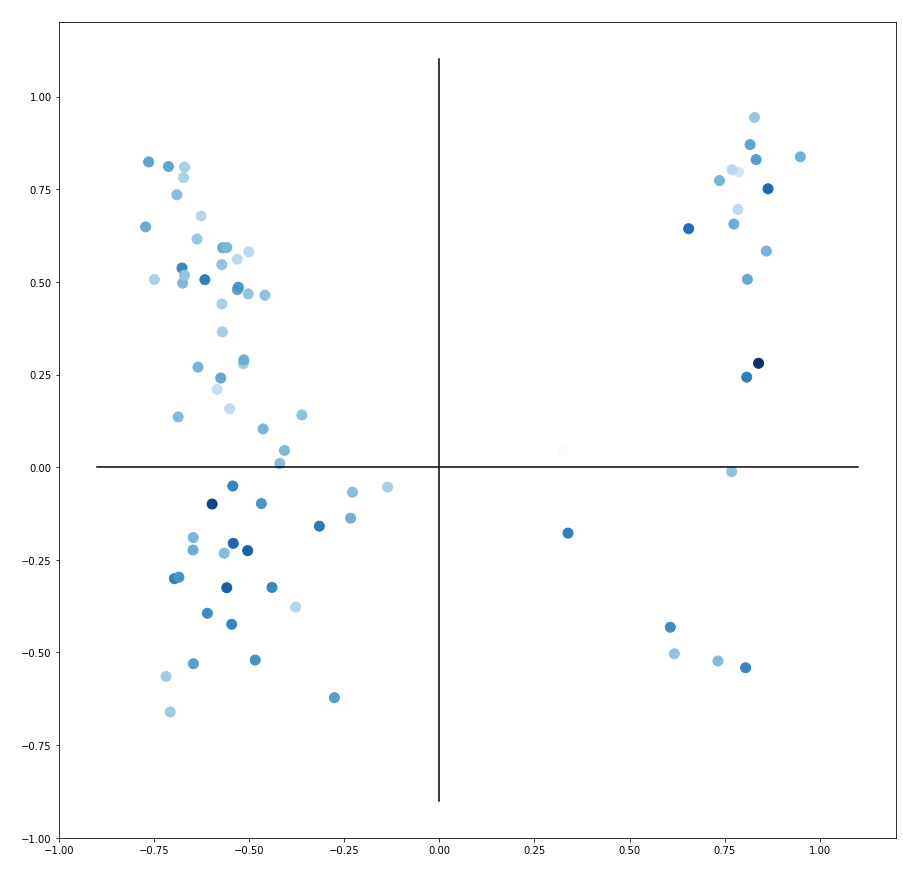

In [17]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.scatter(lossdf["Average Y"],lossdf["Average Z"],c = lossdf["Reduction"],cmap="Blues",s = 100)
plt.xlabel("Y",c="white")
plt.ylabel("Z",c="white")
plt.title("Decrease in Loss",loc="left",c="white")
plt.plot([-.9,1.1],[0,0],c="black")
plt.plot([0,0],[-.9,1.1],c="black")
plt.show()

In [18]:
lossdf["Reduction"].describe(percentiles = [0.1+0.1*i for i in range(9)])

count    81.000000
mean      0.036703
std       0.069885
min      -0.164709
10%      -0.045869
20%      -0.019130
30%       0.002139
40%       0.014651
50%       0.027457
60%       0.041653
70%       0.066007
80%       0.102680
90%       0.118288
max       0.240034
Name: Reduction, dtype: float64

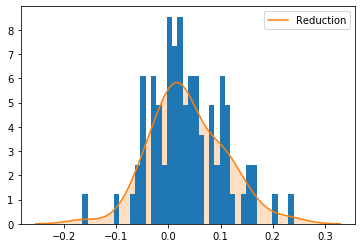

In [19]:
plt.hist(lossdf["Reduction"],density=True,bins=40)
sns.kdeplot(lossdf["Reduction"],shade=True)
plt.show()